In [1]:
#if alreasy installed, don't need to run following codes
#!conda update conda
#!conda config --add channels conda-forge
#!conda install spacy -y
#!python -m spacy download en

#!conda install scikit-learn -y
#!conda install beautifulsoup4 -y
#!conda install elasticsearch -y
#!pip install pyLDAvis

#for error ModuleNotFoundError: No module named 'cycler' when import matplotlib
#remember restart this notebook or using importlib.reload
#!conda remove matplotlib -y
#!conda remove cycler -y
#!pip uninstall cycler -y
#!pip uninstall matplotlib -y
#!pip install cycler
#!pip install matplotlib
!pip install memory_profiler

You are using pip version 9.0.2, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [10]:
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import time 
from sklearn.feature_extraction.text import CountVectorizer 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
  
from Models import DataLoadModel
from Utils import utilTools,utilDataPreprocess,utilLDA, stackoverflowFuncs
import importlib
importlib.reload(DataLoadModel)
importlib.reload(utilTools)
importlib.reload(utilLDA)
importlib.reload(utilDataPreprocess)
importlib.reload(stackoverflowFuncs)

<module 'Utils.stackoverflowFuncs' from 'E:\\my_study_place\\python\\jupyter\\spacy\\Utils\\stackoverflowFuncs.py'>

In [3]:
def loadAndCleanData(force_reload=False, n_jobs=1, force_reload_file=None, force_reload_count=-1):
    try:
        if force_reload:
            raise ValueError("will force reload data...")
        start_time = time.time()
        idlist, data = stackoverflowFuncs.loadCleanedData()
        end_time = time.time()
        print("load {} preprocessed cleaned records in {} Seconds\n".format(len(idlist), end_time - start_time))
    except Exception as e:
        print("load preprocessed data failed, Will retrieve from dataset...")
        start_time = time.time()
        data = DataLoadModel.loadStackoverflowFromXML(force_reload_file, stackoverflowFuncs.parseXMLAndFilterFunc, force_reload_count)
        #data = DataLoadModel.iterLoadStackoverflowFromES(1000)
        end_time = time.time()
        print("Retrieved {} records in {} Seconds".format(len(data), end_time - start_time))
        
        start_time = time.time()
        X_train = [row[1] for row in data]
        idlist = [row[0] for row in data]
        cleaner = utilDataPreprocess.CleanTextTransformer(n_jobs=n_jobs, cleanFunc=stackoverflowFuncs.cleanTextFunc)
        data = cleaner.fit_transform(X_train)
        try:
            stackoverflowFuncs.saveCleanedData(idlist, data)
        except Exception as e:
            print("pickleDump cleaned data Failed")
        end_time = time.time()
        print("clean data in {} Seconds".format(end_time - start_time))
        
    return idlist, data

In [4]:
def loadChunkedTokenizedData(n_chunks=1):
    try:
        data=[]
        for i in range(n_chunks):
            data_tmp = utilTools.pickleLoad(DATAFILE_TOKENIZED+str(i))
            data.extend(data_tmp)
        return data
    except Exception as e:
        print(e)
        print("loadChunkedTokenizedData failed")
        return None
    
def saveVectorizedData(data, vectorizer):
    if idlist is None or data is None or vectorizer is None:
         raise ValueError('you must input two valid objects')
    try:
        utilTools.pickleDump(DATAFILE_VECTORIZED, data)
        utilTools.dillDump(VECTORIZERFILE, vectorizer)
    except Exception as e:
        print(e)
        print("save failed,dataFile={}, vectorizerFile={}".format(DATAFILE_VECTORIZED, VECTORIZERFILE))
        raise e
        
def loadVectorizedData():
    try:
        data = utilTools.pickleLoad(DATAFILE_VECTORIZED)
        vectorizer = utilTools.dillLoad(VECTORIZERFILE)
    except Exception as e:
        print(e)
        print("load failed, dataFile={}, vectorizerFile={}".format(DATAFILE_VECTORIZED, VECTORIZERFILE))
        raise e
        
    return data, vectorizer

In [5]:
#https://stackoverflow.com/questions/11025005/python-sharing-a-dictionary-between-parallel-processes
#https://stackoverflow.com/questions/5442910/python-multiprocessing-pool-map-for-multiple-arguments
def tokenizeAndVectorizeData(data_in, n_chunks, force_reprocess=False, n_jobs=1, min_df=1, max_df = 1.0, max_features=20000):
    #tokenized
    try:
        if force_reprocess:
            raise ValueError("will force reprocess, tokenizing data...")
        start_time = time.time()
        data_to_vectorize = stackoverflowFuncs.loadChunkedTokenizedData(n_chunks)
        tokenFunc = None
        end_time = time.time()
        print("load preprocessed tokenized data in {} Seconds\n".format(end_time - start_time))
    except Exception as e:
        print("load preprocessed tokenized data failed, Will reprocess...")
        data_to_vectorize = data_in
        tokenFunc = stackoverflowFuncs.tokenInChunks
        
    start_time = time.time()
    vectorizer = CountVectorizer(
            # so we can pass it strings
            input='content',
            # turn off preprocessing of strings to avoid corrupting our keys
            lowercase=False,
            preprocessor=lambda x: x,
            # use our token dictionary
            tokenizer=lambda x:x,
            min_df = min_df,
            max_df = max_df, 
            max_features = max_features)
    vectorize_tf = utilDataPreprocess.VectorizationTransformer(n_jobs, n_chunks, tokenFunc, vectorizer)
    tokenized_data, vectorized_data, vectorizer = vectorize_tf.fit_transform(data_to_vectorize)
    end_time = time.time()
    print("tokenized data in {} Seconds\n".format(end_time - start_time))
    try:
        stackoverflowFuncs.saveVectorizedData(vectorized_data, vectorizer)
    except Exception as e:
        print("pickleDump vectorized data Failed")
        
    return tokenized_data, vectorized_data, vectorizer

In [6]:
def vectorizData(data_in, force_reprocess=False, n_chunks=3, n_jobs=1, min_df=1, max_df = 1.0, max_features=20000):
    tokens=None
    try:
        if force_reprocess:
            raise ValueError("will force reprocess data...")
        start_time = time.time()
        data, vectorizer = stackoverflowFuncs.loadVectorizedData()
        end_time = time.time()
        print("load preprocessed vectorized data in {} Seconds\n".format(end_time - start_time))
    except Exception as e:
        print(e)
        print("load preprocessed vectorized data failed, Will reprocess...")
        tokens, data, vectorizer= tokenizeAndVectorieData(data_in, n_chunks=n_chunks, 
                                                          n_jobs=n_jobs, min_df=min_df, 
                                                          max_df=max_df, max_features=max_features)
        
    return tokens, data, vectorizer

Wall time: 0 ns
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 297.16 MiB, increment: 0.00 MiB
load preprocessed data failed, Will retrieve from dataset...
Parse XML [F:\stackoverflow.com-Posts\Posts.xml]Done, total [1001] records!
Retrieved 1001 records in 0.17595577239990234 Seconds
clean data in 4.964111328125 Seconds
load preprocessed tokenized data failed, Will reprocess...
tokenized 1001 records in 7.97199821472168 seconds
tokenized data in 8.219656705856323 Seconds



Trained LDA in 3.5896995067596436 Seconds, n_topics 10, iterations 20, preplexity 1931039.5114734995



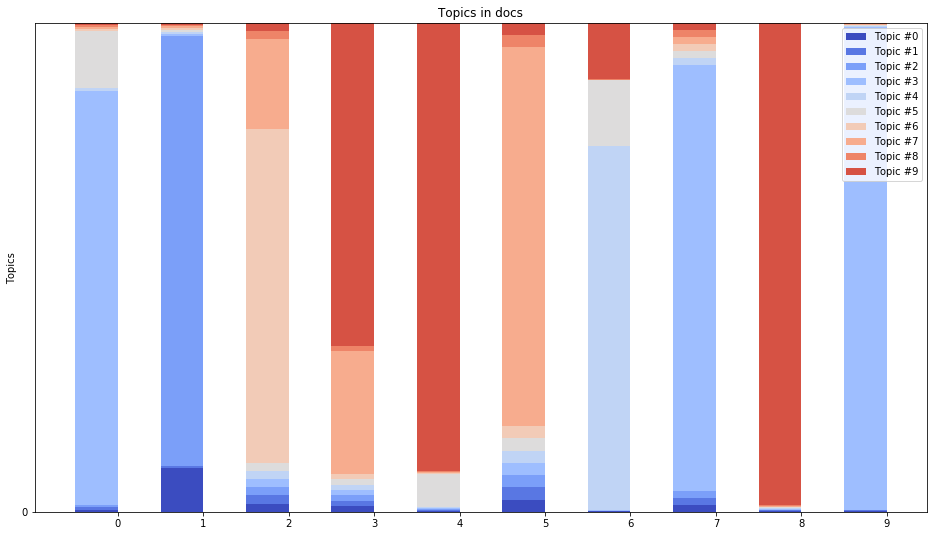

(1001, 10)
4
[0.00454546 0.00454545 0.00454558 0.84739442 0.00454547 0.11624097
 0.00454561 0.00454547 0.00454545 0.00454611]

Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [04/Apr/2018 14:13:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2018 14:13:01] "GET /LDAvis.css HTTP/1.1" 200 -


In [ ]:
%time
%load_ext memory_profiler
#%mprun
%memit

if __name__ == "__main__":
    #Parse XML [F:\stackoverflow.com-Posts\Posts.xml]Done, total [1001] records!
    #Retrieved 1001 records in 0.1178131103515625 Seconds
    #clean data in 2.963881731033325 Seconds
    idlist, cleaned_data = loadAndCleanData(force_reload=True, n_jobs=4, 
                                            force_reload_file=r"F:\stackoverflow.com-Posts\Posts.xml",
                                            force_reload_count=1000)
    #idlist, cleaned_data = loadAndCleanData() 
    #cleaned_data_dict=dict(zip(idlist, cleaned_data))
    
    #tokenized data in 13.708552837371826 Seconds
    #vectorize done in 0.02807474136352539 Seconds
    tokenized_data, vecterized_data, vectorizer = tokenizeAndVectorizeData(cleaned_data,
                                                                          force_reprocess = True,
                                                                          n_chunks=1,
                                                                          n_jobs=2,
                                                                          min_df=1, #5
                                                                          max_df=1.0, #0.6
                                                                          max_features=20000)
    #tokenized_data, vecterized_data, vectorizer = vectorizData(cleaned_data, n_jobs=4,min_df=1,max_df=0.6,max_features=20000)
    #if tokenized_data:
    #    tokenized_data_dict=dict(zip(idlist, tokenized_data))
    #vecterized_data_dict=dict(zip(idlist, vecterized_data))
    print("\n")
    
    #n_jobs=-1, Trained LDA in 303.9054253101349 Seconds
    #n_jobs=1, Trained LDA in 146.29173946380615 Seconds
    start_time = time.time()
    n_topics = 10
    iterations = 20
    lda = utilLDA.trainLDA(vecterized_data, n_topics=n_topics, n_jobs=1, max_iter=iterations, batch_size=32)
    try:
        utilTools.dillDump("./lda.pkl", lda)
    except:
        pass        
    feature_names = vectorizer.get_feature_names()
    topic_list=utilLDA.get_top_words(lda, feature_names, 20)
    train_gamma = lda.transform(vecterized_data)
    train_perplexity = lda.perplexity(vecterized_data, train_gamma)
    end_time = time.time()
    print("Trained LDA in {0} Seconds, n_topics {1}, iterations {2}, preplexity {3}\n"
          .format(end_time - start_time, n_topics, iterations, train_perplexity))
    
    #get document_topic_distribution
    utilLDA.visDocTopicDist(train_gamma[:10])
    print(train_gamma.shape)
    print(idlist[0])
    print(train_gamma[0])
    
    #save result to csv
    df_topics=pd.DataFrame(topic_list, columns=["topic_index", "topic_words"])
    df_topics.to_csv("stackoverflow_topics.csv", sep=",", encoding="utf-8", index=False)
    
    df_doc_topics=pd.DataFrame(train_gamma, columns=["topic #"+str(i) for i in range(n_topics)])
    df_doc_topics['max_coverage'] = pd.Series(idlist).values
    df_doc_topics.to_csv("stackoverflow_topic_coverage.csv", sep=',', encoding='utf-8', index=False)
    
    #utilLDA.visLDA(lda, vecterized_data, vectorizer, utilTools.getIP(), 8889)
    utilLDA.visLDA(lda, vecterized_data, vectorizer, "127.0.0.1",8889)